In [2]:
import os, sys, shutil, subprocess, matplotlib
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy import spatial

path     = os.getcwd()
pathrf   = path+'/opt_refframe'
pathpdb  = path+'/opt_pdb'
pathpar  = path+'/opt_par'
pathbps  = path+'/opt_det-seqs'
pathbpp  = path+'/opt_det-pars'
#pathff   = "/home/rty10/Documents/Experiments/Optimizations/Opt_ForceFields"
pathff   = "C:\\Users\\Young_Research\\Documents\\Rutgers\\Research\\Opt_Forcefields"
# --------------------------------------------------------------------------------
pathinrf  = path+'/initial_conditions/in_refframe'
pathinpdb = path+'/initial_conditions/in_pdb'
pathinpar = path+'/initial_conditions/in_par'

In [3]:
def dna_data(refframe_file, pdb_file):
    """
    Function that will read both a reference frame file and a file of phosphate atoms from a pdb file.
    Goal will be to return a pandas DataFrame with information such as:
    - base-pair origin
    - base-pair's direction of its minor groove
    - the phosphate positions on both its coding (Pi) and complementary (pi) strands
    """
    infile1   = open(refframe_file, 'r')
    infile2   = open(pdb_file, 'r')
    rfdata    = infile1.readlines()
    PDBdata   = infile2.readlines()
    infile1.close()
    infile2.close()
    
    df = pd.DataFrame(columns=["Ox","Oy","Oz",
                               "Dx","Dy","Dz",
                               "-d1x","-d1y","-d1z",
                               "Dcenter","theta",
                               "px","py","pz","qx","qy","qz"])    

    Ncirc = int(rfdata[0].split()[0])
    rfdata  = [i.split() for i in rfdata]
    Odata = []
    Xdata = []
    for i in range(0, Ncirc):
        Odata.append(rfdata[(5*i)+2])
        Xdata.append([rfdata[(5*i)+3][0],
                      rfdata[(5*i)+4][0],
                      rfdata[(5*i)+5][0]])
    
    for i in range(0, len(Odata)):
        df.loc[i, ["Ox","Oy","Oz"]]     = float(Odata[i][0]), float(Odata[i][1]), float(Odata[i][2])
        df.loc[i, ["-d1x","-d1y","-d1z"]] = -1*float(Xdata[i][0]), -1*float(Xdata[i][1]), -1*float(Xdata[i][2])
    
    com = np.array([float((df['Ox'].sum())/Ncirc),
                    float((df['Oy'].sum())/Ncirc),
                    float((df['Oz'].sum())/Ncirc)])
    for i in range(0, len(Odata)):
        orn = np.array(df.loc[i, ["Ox","Oy","Oz"]])
        ocr = np.array(df.loc[i, ["-d1x","-d1y","-d1z"]])
        
        df.loc[i, ["Dx","Dy","Dz"]] = com - orn
        df.loc[i, "Dcenter"]        = sp.spatial.distance.euclidean(com, orn)
        dc = (com - orn)/sp.spatial.distance.euclidean(com, orn)
        
        df.loc[i, "theta"] = np.degrees( np.arccos( np.dot(dc, ocr) ) )
        
    Pdata = []
    for i in range(0, len(PDBdata)):
        if " P " in PDBdata[i]:
            Pdata.append(PDBdata[i])
    Pdata = [[i[30:38],i[38:46],i[46:54]] for i in Pdata]
    # if this opt as a circle, 1 and Ncirc+1 will be identical    
    if len(Pdata) == 2*Ncirc + 2:
        for i in range(0, len(Odata)):
            df.loc[i, ["px","py","pz"]] = float(Pdata[i][0]), float(Pdata[i][1]), float(Pdata[i][2])
            j = ((2*Ncirc + 2)-i)-1
            df.loc[i, ["qx","qy","qz"]] = float(Pdata[j][0]), float(Pdata[j][1]), float(Pdata[j][2])
    elif len(Pdata) == 2*Ncirc:
        for i in range(0, len(Odata)):
            df.loc[i, ["px","py","pz"]] = float(Pdata[i][0]), float(Pdata[i][1]), float(Pdata[i][2])
            j = ((2*Ncirc)-i)-1
            df.loc[i, ["qx","qy","qz"]] = float(Pdata[j][0]), float(Pdata[j][1]), float(Pdata[j][2])
    del rfdata, PDBdata, Odata, Xdata, Pdata
    #df = circ_minor_groove(df)
    #df = circ_major_groove(df)
    return df, com


def load_opt_par_dataframe(filepath, Nseq):
    infile = open(filepath, 'r')
    indata = infile.readlines()
    infile.close()
    indata = [i.rstrip('\n').split() for i in indata]
    header = ['basepair',
    'Shear','Stretch','Stagger','Buckle','Prop-Tw','Opening',
    'Shift','Slide','Rise','Tilt','Roll','Twist']
    indata = indata[3:]
    for i in range(0, len(indata)):
        for j, x in enumerate(indata[i]):
            try:
                indata[i][j] = float(x)
            except ValueError:
                pass
    df = pd.DataFrame.from_records(indata, columns=header)
    del indata
    return df


def circ_minor_groove(dataframe):
    """
    To calculate the width of the minor groove for a circular structure.
    For step 'k', get the average of distances between a pair of phosphates offset by m=-3.
    A: distance from coding p(k+1) to complementary q(k-2)
    B: distance from coding p(k+2) to complementary q(k-1)
    *** For this function, the p phosphates will be complementary to the k-1th step's bp number
    *** for k=10 and circular N=150, p((k+1)+2)=p(k+3)=p([13])
    """
    Nseq = len(dataframe)
    for k in range(0, Nseq):
        if k == 0:
            Pk1 = np.array([dataframe.loc[2,      ["px","py","pz"]]])
            Pk2 = np.array([dataframe.loc[3,      ["px","py","pz"]]])
            pk1 = np.array([dataframe.loc[Nseq-1, ["qx","qy","qz"]]])
            pk2 = np.array([dataframe.loc[Nseq-2, ["qx","qy","qz"]]])
        elif k == 1:
            Pk1 = np.array([dataframe.loc[3,      ["px","py","pz"]]])
            Pk2 = np.array([dataframe.loc[4,      ["px","py","pz"]]])
            pk1 = np.array([dataframe.loc[0,      ["qx","qy","qz"]]])
            pk2 = np.array([dataframe.loc[Nseq-1, ["qx","qy","qz"]]])
        elif k == Nseq-3:
            Pk1 = np.array([dataframe.loc[k+2,    ["px","py","pz"]]])
            Pk2 = np.array([dataframe.loc[0,      ["px","py","pz"]]])
            pk1 = np.array([dataframe.loc[k-1,    ["qx","qy","qz"]]])
            pk2 = np.array([dataframe.loc[k-2,    ["qx","qy","qz"]]])
        elif k == Nseq-2:
            Pk1 = np.array([dataframe.loc[0,      ["px","py","pz"]]])
            Pk2 = np.array([dataframe.loc[1,      ["px","py","pz"]]])
            pk1 = np.array([dataframe.loc[k-1,    ["qx","qy","qz"]]])
            pk2 = np.array([dataframe.loc[k-2,    ["qx","qy","qz"]]])
        elif k == Nseq-1:
            Pk1 = np.array([dataframe.loc[1,      ["px","py","pz"]]])
            Pk2 = np.array([dataframe.loc[2,      ["px","py","pz"]]])
            pk1 = np.array([dataframe.loc[k-1,    ["qx","qy","qz"]]])
            pk2 = np.array([dataframe.loc[k-2,    ["qx","qy","qz"]]])
        else:
            Pk1 = np.array([dataframe.loc[k+2,    ["px","py","pz"]]])
            Pk2 = np.array([dataframe.loc[k+3,    ["px","py","pz"]]])
            pk1 = np.array([dataframe.loc[k-1,    ["qx","qy","qz"]]])
            pk2 = np.array([dataframe.loc[k-2,    ["qx","qy","qz"]]])
        
        A = sp.spatial.distance.euclidean(Pk1, pk2)
        B = sp.spatial.distance.euclidean(Pk2, pk1)
        mg = (1/2)*( A + B )
        dataframe.loc[k, "W-min"] = mg
    del Nseq
    return dataframe

def circ_major_groove(dataframe):
    """
    To calculate the width of the major groove for a circular structure.
    For step 'k', get the average of distances between a pair of phosphates offset by m=4.
    mg = distance from coding p((k+1)-2)=p(k-1) to complementary q(k+2)
    """
    Nseq = len(dataframe)
    for k in range(0, Nseq):
        if k == 0:
            Pk2 = np.array([dataframe.loc[Nseq-1, ["px","py","pz"]]])
            pk2 = np.array([dataframe.loc[2,      ["qx","qy","qz"]]])
        elif k == 1:
            Pk2 = np.array([dataframe.loc[0,      ["px","py","pz"]]])
            pk2 = np.array([dataframe.loc[3,      ["qx","qy","qz"]]])
        elif k == Nseq-2:
            Pk2 = np.array([dataframe.loc[k-1,    ["px","py","pz"]]])
            pk2 = np.array([dataframe.loc[0,      ["qx","qy","qz"]]])
        elif k == Nseq-1:
            Pk2 = np.array([dataframe.loc[k-1,    ["px","py","pz"]]])
            pk2 = np.array([dataframe.loc[1,      ["qx","qy","qz"]]])
        else:
            Pk2 = np.array([dataframe.loc[k-1,    ["px","py","pz"]]])
            pk2 = np.array([dataframe.loc[k+2,    ["qx","qy","qz"]]])
            
        mg = sp.spatial.distance.euclidean(Pk2, pk2)
        dataframe.loc[k, "W-maj"] = mg
    del Nseq
    return dataframe

def load_forcefield(ffpath, forcefield):
    """
    Function to generate a dataframe with rest state values from an optimization forcefield
    and another dataframe with elastic force constants of the same forcefield
    """
    for filename in os.listdir(ffpath+'/RestStateParameters'):
        if forcefield in filename:
            infile1 = open(ffpath+'/RestStateParameters/'+filename, 'r')
    indata1 = infile1.readlines()
    indata1 = [i.replace("={"," ").replace(", "," ").replace("}","").rstrip('\n').split() for i in indata1]
    for i in range(0, len(indata1)):
        for j, x in enumerate(indata1[i]):
            try:	indata1[i][j] = float(x)
            except ValueError:	pass
    if forcefield == 'Olson1998' or forcefield == 'olson':
        infile2 = open(ffpath+'/ForceConstants/ForceConstants_Olson1998.txt', 'r')
    else:
        infile2 = open(ffpath+'/ForceConstants/ForceConstants_IdealDNA.txt', 'r')
    indata2 = infile2.readlines()
    indata2 = [i.replace("={"," ").replace(", "," ").replace("}","").rstrip('\n').split() for i in indata2]
    for i in range(0, len(indata2)):
        for j, x in enumerate(indata2[i]):
            try:	indata2[i][j] = float(x)
            except ValueError:	pass
    header1 = ['dimer','tilt','roll','twist','shift','slide','rise']
    header2 =['dimer',
    'TiltTilt','TiltRoll','TiltTwist','TiltShift','TiltSlide','TiltRise',
    'RollTilt','RollRoll','RollTwist','RollShift','RollSlide','RollRise',
    'TwistTilt','TwistRoll','TwistTwist','TwistShift','TwistSlide','TwistRise',
    'ShiftTilt','ShiftRoll','ShiftTwist','ShiftShift','ShiftSlide','ShiftRise',
    'SlideTilt','SlideRoll','SlideTwist','SlideShift','SlideSlide','SlideRise',
    'RiseTilt','RiseRoll','RiseTwist','RiseShift','RiseSlide','RiseRise']
    df1 = pd.DataFrame.from_records(indata1, columns=header1)
    df2 = pd.DataFrame.from_records(indata2, columns=header2)
    indata2 = infile2.readlines()
    del indata1, indata2
    return df1, df2

def insert_bpstep_seq_circular(opt_par_dataframe):
    """
    From a dataframe with a column of base-pairs, generate the dimer and tetramer for each bp.
    Add new dimer and tetramer columns to dataframe.
    Note: this is for circular constructions
    """
    bpseq  = opt_par_dataframe['basepair']
    for k in range(0, len(bpseq)):
        first, second, third, fourth = k-2, k-1, k, k+1 
        if k-2 == -2:
            first  = (Nseq - 2)
            second = (Nseq - 1)
        elif k-2 == -1:
            first = (Nseq - 1)
        elif k == Nseq-1:
            fourth = 0
        elif k == Nseq:
            second = (Nseq-1)
            third  = 0
            fourth = 1
        a = bpseq[first].split('-')[0]
        b = bpseq[second].split('-')[0]
        c = bpseq[third].split('-')[0]
        d = bpseq[fourth].split('-')[0]
        dimerstep = "".join((b, c))
        tetrastep = "".join((a, b, c, d))
        opt_par_dataframe.at[k, 'dimer'] = dimerstep
        opt_par_dataframe.at[k, 'tetramer'] = tetrastep
    return opt_par_dataframe

def insert_bps_bend(opt_par_dataframe):
    """
    Function that takes the tilt and roll columns from a loaded dataframe and determines the bend angle.
    """
    for k in range(0, len(opt_par_dataframe)):
        x = float(opt_par_dataframe.loc[k, 'Tilt'])
        y = float(opt_par_dataframe.loc[k, 'Roll'])
        opt_par_dataframe.loc[k, 'Bend'] = float(np.sqrt(x**2 + y**2))
    return opt_par_dataframe

def insert_bps_energy(Nseq, opt_par_dataframe, reststate_par_dataframe, elastic_constants_dataframe):
    """
    Function that determines the energy per base-pair step.
    Must have:
    - loaded rest state dataframe
    - loaded elastic force constant dataframe
    - column with dimer and/or tetramer steps
    """
    opt_par_dataframe.loc[0, 'Energy'] = float(0)
    for k in range(1, len(opt_par_dataframe)):
        dim = opt_par_dataframe.loc[k, 'dimer']
        oshift, oslide, orise, otilt, oroll, otwist = [j for j in opt_par_dataframe.loc[k, 'Shift':'Twist']]
        A = np.array([otilt, oroll, otwist, oshift, oslide, orise])
        for j in range(0, len(reststate_par_dataframe)):
            if reststate_par_dataframe.loc[j, 'dimer'] == dim:
                B = np.array([z for z in reststate_par_dataframe.loc[j, 'tilt':'rise']])
        for j in range(0, len(elastic_constants_dataframe)):
            if elastic_constants_dataframe.loc[j, 'dimer'] == dim:
                F = np.array([[z for z in elastic_constants_dataframe.loc[j, 'TiltTilt':'TiltRise']],
                              [z for z in elastic_constants_dataframe.loc[j, 'RollTilt':'RollRise']],
                              [z for z in elastic_constants_dataframe.loc[j, 'TwistTilt':'TwistRise']],
                              [z for z in elastic_constants_dataframe.loc[j, 'ShiftTilt':'ShiftRise']],
                              [z for z in elastic_constants_dataframe.loc[j, 'SlideTilt':'SlideRise']],
                              [z for z in elastic_constants_dataframe.loc[j, 'RiseTilt':'RiseRise']]])
        opt_par_dataframe.loc[k, 'Energy'] = (1/2)*np.trace( (A-B) * F * (A-B) )
    return opt_par_dataframe


# --- Output new parameter file ---
def newfile_bpsdata(Nseq, main_dataframe, outputfilepath, outputname):
    """
    bp, dimer, tetramer, tilt, roll, bend, twist, energy, dcenter, anglecenter, Wmaj, Wmin, ...
    """
    A = main_dataframe
    outfile = open(outputfilepath+'/'+outputname+'_bps-data.txt', 'w')
    outfile.write(str(Nseq)+'  # base pairs\n')
    if not "initial" in str(outputfilepath):
        outfile.write("{:<4}{:>6}{:>9}{:>10}{:>10}{:>10}{:>10}{:>10}{:>10}{:>10}{:>10}{:>10}\n".format(
        'bp','dimer','tetramer','Tilt','Roll','Bend','Twist','Energy','Dcenter','theta','W-maj','W-min'
        ))
        for i in range(0, len(A)):
            outfile.write("{:<4}{:>6}{:>9}{:>10}{:>10}{:>10}{:>10}{:>10}{:>10}{:>10}{:>10}{:>10}\n".format(
            A.loc[i, 'basepair'], A.loc[i, 'dimer'], A.loc[i, 'tetramer'],
            round(A.loc[i, 'Tilt'],5),round(A.loc[i, 'Roll'],5),round(A.loc[i, 'Bend'],5),round(A.loc[i, 'Twist'],5),round(A.loc[i, 'Energy'], 5),
            round(A.loc[i, 'Dcenter'], 5), round(A.loc[i, 'theta'], 5), round(A.loc[i, 'W-maj'], 5), round(A.loc[i, 'W-min'], 5) 
            ))
        outfile.close()
    else:
        outfile.write("{:<4}{:>6}{:>9}{:>10}{:>10}{:>10}{:>10}{:>10}{:>10}{:>10}{:>10}\n".format(
        'bp','dimer','tetramer','Tilt','Roll','Bend','Twist','Dcenter','theta','W-maj','W-min'
        ))
        for i in range(0, len(A)):
            outfile.write("{:<4}{:>6}{:>9}{:>10}{:>10}{:>10}{:>10}{:>10}{:>10}{:>10}{:>10}\n".format(
            A.loc[i, 'basepair'], A.loc[i, 'dimer'], A.loc[i, 'tetramer'],
            round(A.loc[i, 'Tilt'],5),round(A.loc[i, 'Roll'],5),round(A.loc[i, 'Bend'],5),round(A.loc[i, 'Twist'],5),
            round(A.loc[i, 'Dcenter'], 5), round(A.loc[i, 'theta'], 5), round(A.loc[i, 'W-maj'], 5), round(A.loc[i, 'W-min'], 5) 
            ))
        outfile.close()
    return

def load_optdetailed_df(filepath):
    infile = open(filepath, 'r')
    indata = infile.readlines()
    infile.close()
    indata = [i.rstrip('\n').split() for i in indata]
    for i in range(0, len(indata)):
        for j, x in enumerate(indata[i]):
            try:
                indata[i][j] = float(x)
            except ValueError:
                pass
    df = pd.DataFrame.from_records(indata[2:], columns=indata[1:2])
    df.index = np.arange(1, len(df)+1)
    del indata
    return df

def df_reststate(path):
    infile1 = open(path, 'r')
    indata1 = infile1.readlines()
    infile1.close()            
    indata1 = [i.replace("={"," ").replace(", "," ").replace("}","").rstrip('\n').split() for i in indata1]
    rsdf = pd.DataFrame.from_records(indata1, columns=['dimer','Tilt','Roll','Twist','shift','slide','rise'])
    rsdf = rsdf.astype({'Tilt':"float64",'Roll':"float64",'Twist':"float64",'shift':"float64",'slide':"float64",'rise':"float64"})
    rsdf = rsdf.set_index('dimer')
    return rsdf


# Sample Analysis

## Initial Condition Data

# Sequence + RestState Comparisons

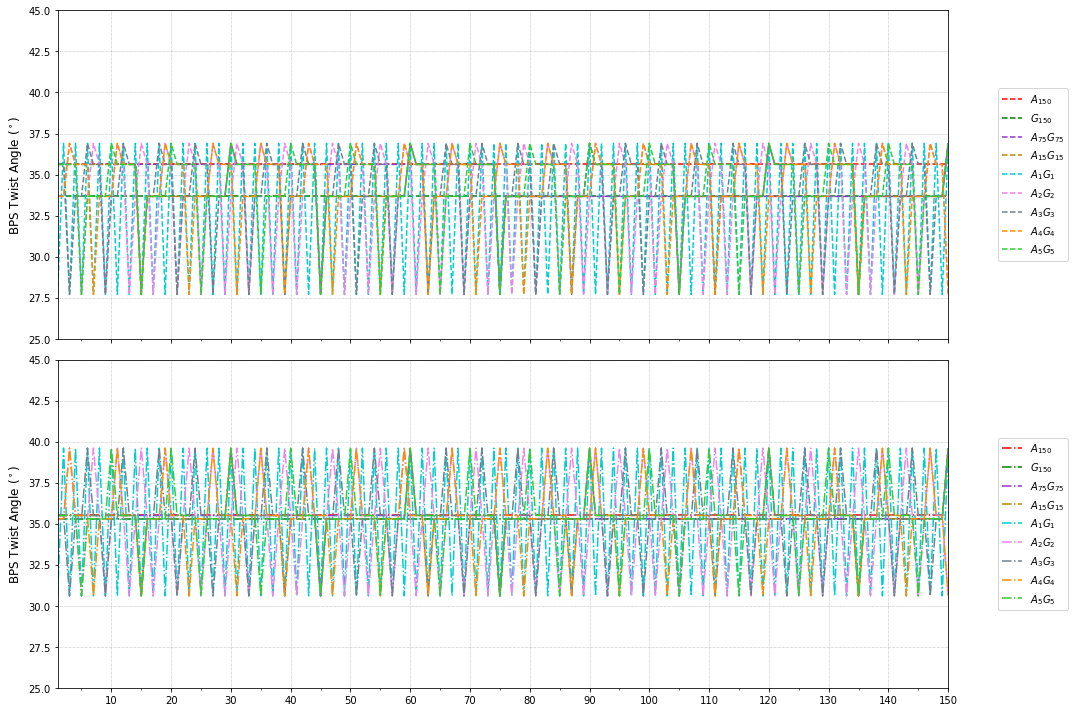

<Figure size 432x288 with 0 Axes>

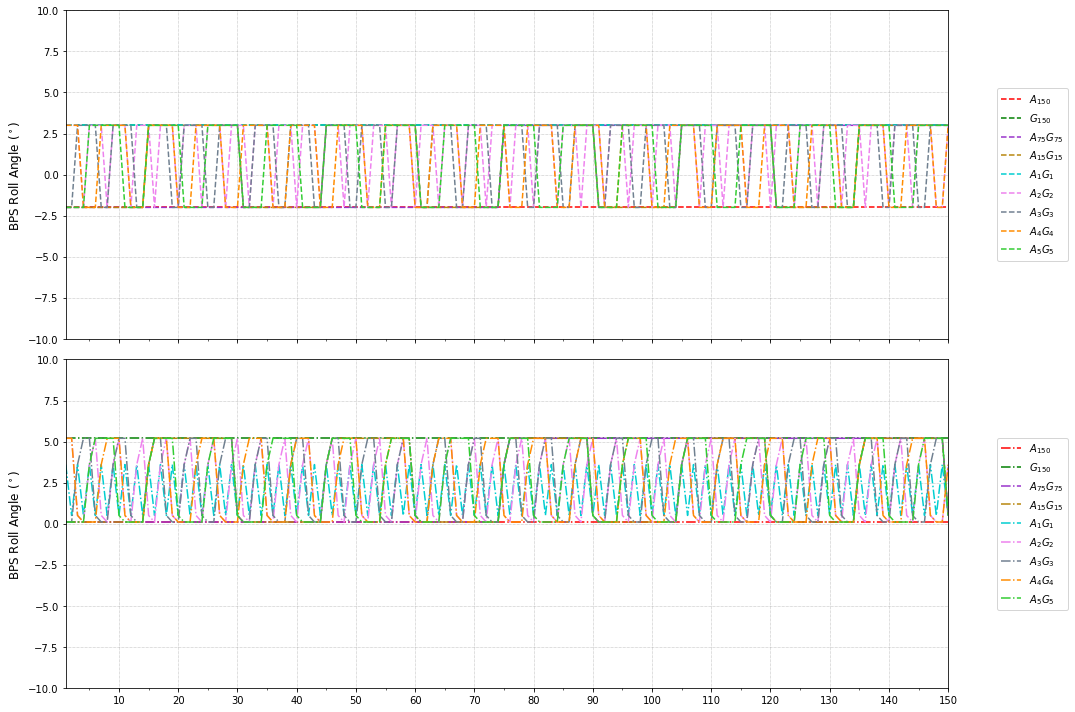

<Figure size 432x288 with 0 Axes>

In [7]:
limits = {'Twist':[25,45],'Roll':[-10,10]}
par_labels = {'Twist':'BPS Twist Angle ($^\circ$)','Roll':'BPS Roll Angle ($^\circ$)'}

inseqs    = ["col"+str(i).zfill(2) for i in range(1, 10)]
inseqs1   = ['$A_{150}$','$G_{150}$','$A_{75}G_{75}$','$A_{15}G_{15}$','$A_1G_1$','$A_2G_2$','$A_3G_3$','$A_4G_4$','$A_5G_5$']
labels    = {inseqs[i]:inseqs1[i] for i in range(0, len(inseqs))}
colorlist = ['red','green','darkorchid','darkgoldenrod','darkturquoise','violet','slategrey','darkorange','limegreen']
colors    = {inseqs[i]:colorlist[i] for i in range(0, len(inseqs))}
    
#for x in range(0, len(inseqs)):
for Par in ['Twist','Roll']:
    df1k = pd.read_csv(pathbpp+"/pcirc_kabsch_"+Par, index_col=0)
    df1o = pd.read_csv(pathbpp+"/pcirc_olson_"+Par, index_col=0)
    
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(15,10), sharex=True)
    for i in range(0, len(inseqs)):
        df1k.plot(y='rs_'+inseqs[i], color=colors[inseqs[i]], 
                style='--',
                ylim=(limits[Par][0], limits[Par][1]),
                ax=ax1)
        df1o.plot(y='rs_'+inseqs[i], color=colors[inseqs[i]], 
                style='-.',
                ylim=(limits[Par][0], limits[Par][1]),
                ax=ax2)
    for ax in [ax1, ax2]:
        ax.xaxis.set_major_locator(plt.MultipleLocator(10))
        ax.xaxis.set_minor_locator(plt.MultipleLocator(5))
        ax.grid(linestyle=':', linewidth='0.5', color='grey')
        ax.set_ylabel(par_labels[Par], fontsize=12)
        ax.legend(labels=[i for i in inseqs1], loc='center left', bbox_to_anchor=(1.05, 0.50))
    plt.tight_layout()
    plt.show()
    #plt.savefig("col150_bps-comp_"+Par+"_"+inseqs[x], dpi=300, transparent=True, )
    plt.clf()
    del df1k, df1o
del inseqs, inseqs1, labels, colorlist,colors,limits,par_labels

In [30]:
limits = {'Twist':[25,45],'Roll':[-10,10]}
par_labels = {'Twist':'BPS Twist Angle ($^\circ$)','Roll':'BPS Roll Angle ($^\circ$)'}

inseqs    = ["col"+str(i).zfill(2) for i in range(1, 10)]
inseqs1   = ['$A_{150}$','$G_{150}$','$A_{75}G_{75}$','$A_{15}G_{15}$','$A_1G_1$','$A_2G_2$','$A_3G_3$','$A_4G_4$','$A_5G_5$']
labels    = {inseqs[i]:inseqs1[i] for i in range(0, len(inseqs))}
colorlist = ['gold','cyan',
             'green','green','green','green','green','green','green']
colors    = {inseqs[i]:colorlist[i] for i in range(0, len(inseqs))}
    
#for x in range(0, len(inseqs)):
for Par in ['Twist','Roll']:
    df1k = pd.read_csv(pathbpp+"/pcirc_kabsch_"+Par, index_col=0)
    df1o = pd.read_csv(pathbpp+"/pcirc_olson_"+Par, index_col=0)
    
    df2k = pd.read_csv(pathbpp+"/oring_kabsch_"+Par, index_col=0)
    df2o = pd.read_csv(pathbpp+"/oring_olson_"+Par, index_col=0)
    
    dfinp = load_optdetailed_df(path+'/initial_conditions/pcirc_bps-data.txt')
    dfinp = dfinp.astype({'Twist':"float64",'Roll':"float64"})
    dfino = load_optdetailed_df(path+'/initial_conditions/oring_bps-data.txt')
    dfino = dfino.astype({'Twist':"float64",'Roll':"float64"})
    
    for i in range(0, len(inseqs)):
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 5), sharex=True)
        df = pd.DataFrame()
        df['Model Rest State']      = df1k['rs_'+inseqs[i]]
        df['Initial State']         = dfinp[Par]
        df['Optimized State']       = df1k['opt_'+inseqs[i]]
        df = df[['Initial State','Model Rest State', 'Optimized State']]
        df.plot(color=['black', 'magenta',colors[inseqs[i]]],
                style=[':',':','-'],
                ylim=(limits[Par][0], limits[Par][1]),
                legend=False,
                ax=ax1)
        del df
        
        df = pd.DataFrame()
        df['Model Rest State']      = df1o['rs_'+inseqs[i]]
        df['Initial State']         = dfinp[Par]
        df['Optimized State']       = df1o['opt_'+inseqs[i]]
        df = df[['Initial State','Model Rest State', 'Optimized State']]
        
        df.plot(color=['black','magenta',colors[inseqs[i]]],
                style=[':',':','-'],
                ylim=(limits[Par][0], limits[Par][1]),
                legend=False,
                ax=ax2)

        for ax in [ax1, ax2]:
            ax.xaxis.set_major_locator(plt.MultipleLocator(10))
            ax.xaxis.set_minor_locator(plt.MultipleLocator(5))
            ax.grid(linestyle=':', linewidth='0.5', color='grey')
            ax.set_ylabel(par_labels[Par], fontsize=12)
            #ax.legend(title=titles[ax], loc='lower right')
        plt.legend(title=labels[inseqs[i]], loc='center left', bbox_to_anchor=(1.05, 0.50))
        plt.tight_layout()
        #plt.show()
        plt.savefig('col150_pcirc_'+inseqs[i]+'_'+Par+'_InRsOpt-Comps', dpi=300, transparent=True)
        plt.clf()
        del df
        
        
        fig, (ax3,ax4) = plt.subplots(nrows=1, ncols=2, figsize=(20, 5), sharex=True)
        
        df = pd.DataFrame()
        df['Model Rest State']      = df2k['rs_'+inseqs[i]]
        df['Initial State']         = dfino[Par]
        df['Optimized State']       = df2k['opt_'+inseqs[i]]
        df = df[['Initial State','Model Rest State', 'Optimized State']]
        df.plot(color=['black','magenta',colors[inseqs[i]]],
                style=[':',':','-'],
                ylim=(limits[Par][0], limits[Par][1]),
                legend=False,
                ax=ax3)
        del df
        df = pd.DataFrame()
        df['Model Rest State']      = df2o['rs_'+inseqs[i]]
        df['Initial State']         = dfino[Par]
        df['Optimized State']    = df2o['opt_'+inseqs[i]]
        df = df[['Initial State','Model Rest State', 'Optimized State']]
        df.plot(color=['black','magenta',colors[inseqs[i]]],
                style=[':',':','-'],
                ylim=(limits[Par][0], limits[Par][1]),
                ax=ax4)
        for ax in [ax3, ax4]:
            ax.xaxis.set_major_locator(plt.MultipleLocator(10))
            ax.xaxis.set_minor_locator(plt.MultipleLocator(5))
            ax.grid(linestyle=':', linewidth='0.5', color='grey')
            ax.set_ylabel(par_labels[Par], fontsize=12)
            #ax.legend(title=titles[ax], loc='lower right')
        plt.legend(title=labels[inseqs[i]], loc='center left', bbox_to_anchor=(1.05, 0.50))
        plt.tight_layout()
        #plt.show()
        plt.savefig('col150_oring_'+inseqs[i]+'_'+Par+'_InRsOpt-Comps', dpi=300, transparent=True)
        plt.clf()
        del df
        
    del df1k, df1o, df2k, df2o, dfinp, dfino
del inseqs, inseqs1, labels, colorlist,colors,limits,par_labels

/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

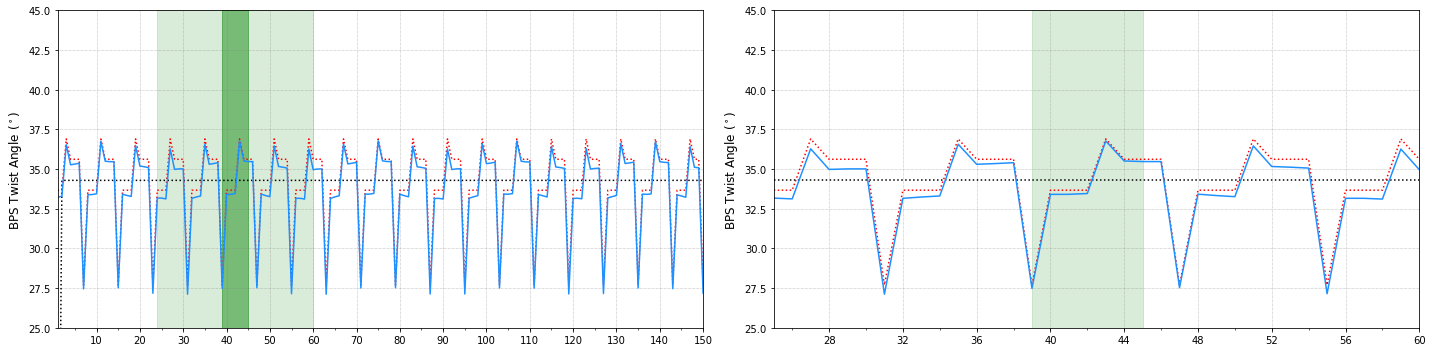

<Figure size 432x288 with 0 Axes>

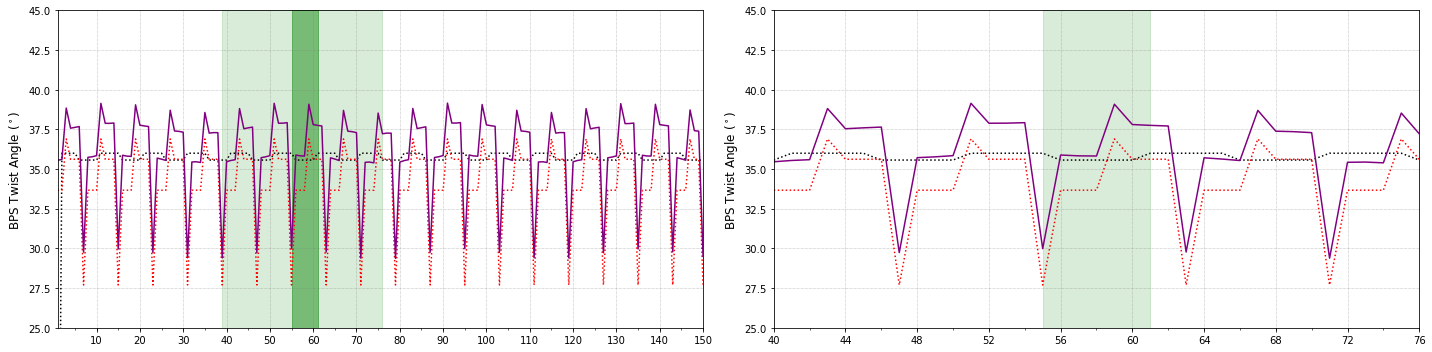

<Figure size 432x288 with 0 Axes>

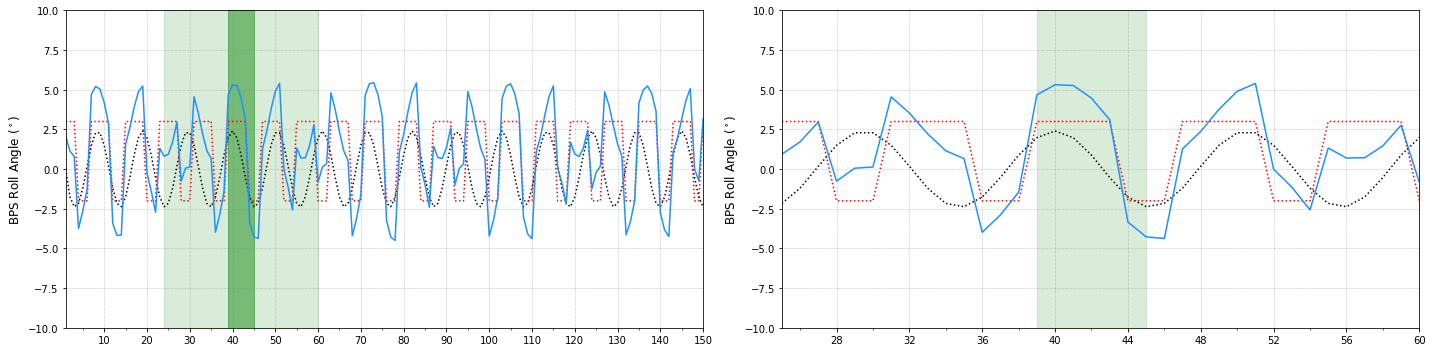

<Figure size 432x288 with 0 Axes>

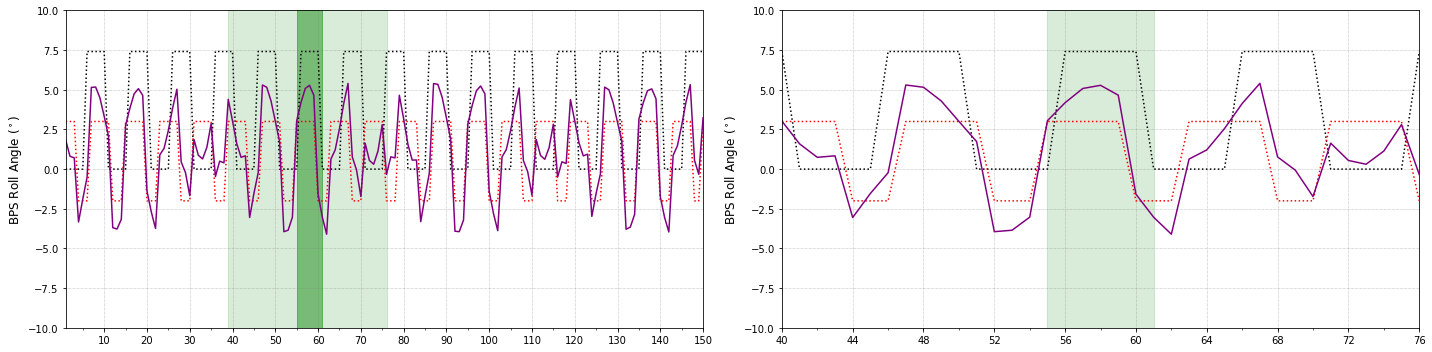

<Figure size 432x288 with 0 Axes>

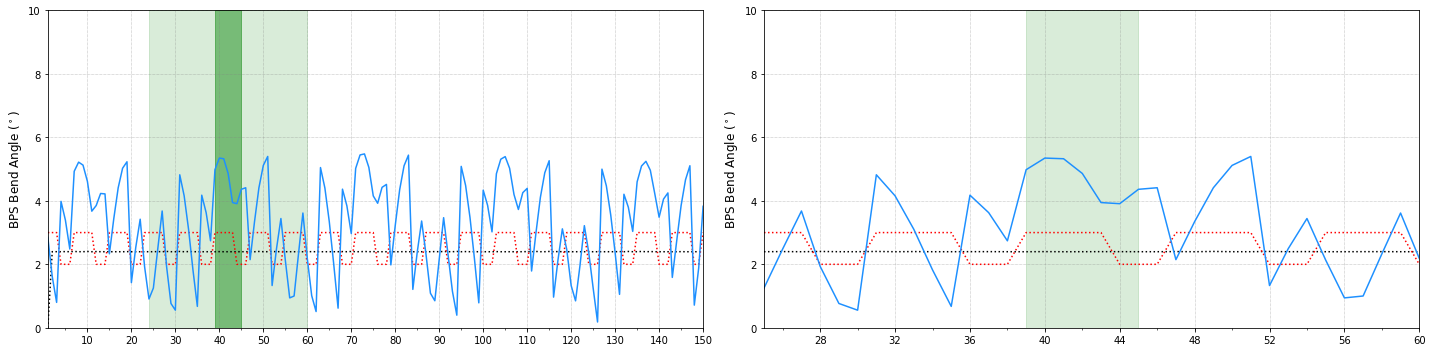

<Figure size 432x288 with 0 Axes>

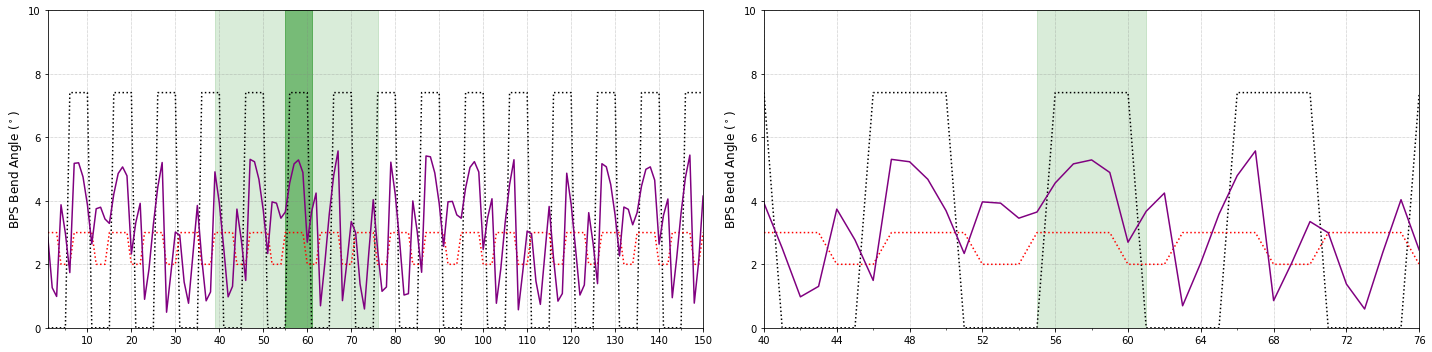

<Figure size 432x288 with 0 Axes>

In [28]:
limits = {'Twist':[25,45],'Roll':[-10,10], 'Bend':[0, 10]}
par_labels = {'Twist':'BPS Twist Angle ($^\circ$)',
              'Roll':'BPS Roll Angle ($^\circ$)',
              'Bend':'BPS Bend Angle ($^\circ$)'}

inseqs    = ["col08"]
inseqs1   = ['$A_4G_4$']
labels    = {inseqs[i]:inseqs1[i] for i in range(0, len(inseqs))}
    
#for x in range(0, len(inseqs)):
for Par in ['Twist','Roll', 'Bend']:
    df1k = pd.read_csv(pathbpp+"/pcirc_kabsch_"+Par, index_col=0)
    df1o = pd.read_csv(pathbpp+"/pcirc_olson_"+Par, index_col=0)
    
    df2k = pd.read_csv(pathbpp+"/oring_kabsch_"+Par, index_col=0)
    df2o = pd.read_csv(pathbpp+"/oring_olson_"+Par, index_col=0)
    
    dfinp = load_optdetailed_df(path+'/initial_conditions/pcirc_bps-data.txt')
    dfinp = dfinp.astype({'Twist':"float64",'Roll':"float64", 'Bend':"float64"})
    dfino = load_optdetailed_df(path+'/initial_conditions/oring_bps-data.txt')
    dfino = dfino.astype({'Twist':"float64",'Roll':"float64",  'Bend':"float64"})
    
    for i in range(0, len(inseqs)):
        # PLANAR CIRCLE
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
        df = pd.DataFrame()
        df['Model Rest State']      = df1k['rs_'+inseqs[i]]
        df['Initial State']         = dfinp[Par]
        df['Optimized State']       = df1k['opt_'+inseqs[i]]
        df = df[['Initial State','Model Rest State', 'Optimized State']]
        
        df.plot(color=['black', 'red','dodgerblue'],
                style=[':',':','-'],
                ylim=(limits[Par][0], limits[Par][1]),
                legend=False,
                ax=ax1)
        ax1.xaxis.set_major_locator(plt.MultipleLocator(10))
        ax1.xaxis.set_minor_locator(plt.MultipleLocator(5))
        ax1.axvspan(24, 60, color='green', alpha=0.15)
        ax1.axvspan(39, 45, color='green',alpha=0.45)
        
        df[24:60].plot(color=['black', 'red','dodgerblue'],
                style=[':',':','-'],
                ylim=(limits[Par][0], limits[Par][1]),
                legend=False,
                ax=ax2)
        ax2.xaxis.set_major_locator(plt.MultipleLocator(4))
        ax2.xaxis.set_minor_locator(plt.MultipleLocator(2))
        ax2.axvspan(39, 45, color='green',alpha=0.15)
        
        #del df
        
        '''
        df = pd.DataFrame()
        df['Model Rest State']      = df1o['rs_'+inseqs[i]]
        df['Initial State']         = dfinp[Par]
        df['Optimized State']       = df1o['opt_'+inseqs[i]]
        df = df[['Initial State','Model Rest State', 'Optimized State']]
        
        df.plot(color=['black','red','dodgerblue'],
                style=[':',':','-'],
                ylim=(limits[Par][0], limits[Par][1]),
                legend=False,
                ax=ax2)
        '''

        for ax in [ax1, ax2]:
            ax.grid(linestyle=':', linewidth='0.5', color='grey')
            ax.set_ylabel(par_labels[Par], fontsize=12)
            
        #plt.legend(title=labels[inseqs[i]], loc='center left', bbox_to_anchor=(1.05, 0.50))
        plt.tight_layout()
        plt.show()
        #plt.savefig('col150_A4G4-pcirc_'+Par+'_Comp', dpi=300, transparent=True)
        plt.clf()
        #del df
        
        # O-RING
        fig, (ax3,ax4) = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
        
        df = pd.DataFrame()
        df['Model Rest State']      = df2k['rs_'+inseqs[i]]
        df['Initial State']         = dfino[Par]
        df['Optimized State']       = df2k['opt_'+inseqs[i]]
        df = df[['Initial State','Model Rest State', 'Optimized State']]
        
        df.plot(color=['black','red','purple'],
                style=[':',':','-'],
                ylim=(limits[Par][0], limits[Par][1]),
                legend=False,
                ax=ax3)
        ax3.xaxis.set_major_locator(plt.MultipleLocator(10))
        ax3.xaxis.set_minor_locator(plt.MultipleLocator(5))
        ax3.axvspan(39, 76, color='green', alpha=0.15)
        ax3.axvspan(55, 61, color='green',alpha=0.45)
        
        df[39:76].plot(color=['black','red','purple'],
                style=[':',':','-'],
                ylim=(limits[Par][0], limits[Par][1]),
                legend=False,
                ax=ax4)
        ax4.xaxis.set_major_locator(plt.MultipleLocator(4))
        ax4.xaxis.set_minor_locator(plt.MultipleLocator(2))
        ax4.axvspan(55, 61, color='green',alpha=0.15)
        
        #del df
        '''
        df = pd.DataFrame()
        df['Model Rest State']      = df2o['rs_'+inseqs[i]]
        df['Initial State']         = dfino[Par]
        df['Optimized State']    = df2o['opt_'+inseqs[i]]
        df = df[['Initial State','Model Rest State', 'Optimized State']]
        df.plot(color=['black','red','purple'],
                style=[':',':','-'],
                ylim=(limits[Par][0], limits[Par][1]),
                legend=False,
                ax=ax4)
        '''
        for ax in [ax3, ax4]:
            ax.grid(linestyle=':', linewidth='0.5', color='grey')
            ax.set_ylabel(par_labels[Par], fontsize=12)
            
        #plt.legend(title=labels[inseqs[i]], loc='center left', bbox_to_anchor=(1.05, 0.50))
        plt.tight_layout()
        plt.show()
        #plt.savefig('col150_A4G4-oring_'+Par+'_Comp', dpi=300, transparent=True)
        plt.clf()
        #del df
    del df1k, df1o, df2k, df2o, dfinp, dfino
        

del inseqs, inseqs1, labels

In [27]:
df

,Initial State,Model Rest State,Optimized State
1,0.00,3.0,2.85296
2,0.00,3.0,1.26144
3,0.00,3.0,0.98791
4,0.00,2.0,3.87599
5,0.00,2.0,2.96958
6,7.41,2.0,1.73914
7,7.41,3.0,5.18148
8,7.41,3.0,5.19870
9,7.41,3.0,4.75504
10,7.41,3.0,3.87920


In [32]:
limits = {'Twist':[25,45],'Roll':[-10,10]}
par_labels = {'Twist':'BPS Twist Angle ($^\circ$)','Roll':'BPS Roll Angle ($^\circ$)'}

inseqs    = ["col"+str(i).zfill(2) for i in range(1, 10)]
inseqs1   = ['$A_{150}$','$G_{150}$','$A_{75}G_{75}$','$A_{15}G_{15}$','$A_1G_1$','$A_2G_2$','$A_3G_3$','$A_4G_4$','$A_5G_5$']
labels    = {inseqs[i]:inseqs1[i] for i in range(0, len(inseqs))}
colorlist = ['gold','cyan',
             'green','green','green','green','green','green','green']
colors    = {inseqs[i]:colorlist[i] for i in range(0, len(inseqs))}
    
#for x in range(0, len(inseqs)):
for Par in ['Roll']:
    df1k = pd.read_csv(pathbpp+"/pcirc_kabsch_"+Par, index_col=0)
    df1o = pd.read_csv(pathbpp+"/pcirc_olson_"+Par, index_col=0)
    
    df2k = pd.read_csv(pathbpp+"/oring_kabsch_"+Par, index_col=0)
    df2o = pd.read_csv(pathbpp+"/oring_olson_"+Par, index_col=0)
    
    dfinp = load_optdetailed_df(path+'/initial_conditions/pcirc_bps-data.txt')
    dfinp = dfinp.astype({'Twist':"float64",'Roll':"float64"})
    dfinp.index = np.arange(1, len(dfinp) + 1)
    dfino = load_optdetailed_df(path+'/initial_conditions/oring_bps-data.txt')
    dfino = dfino.astype({'Twist':"float64",'Roll':"float64"})
    dfino.index = np.arange(1, len(dfino) + 1)
    
    for i in range(0, len(inseqs)):
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 5), sharex=True)
        df = pd.DataFrame()
        df['Model Rest State']      = df1k['rs_'+inseqs[i]]
        df['Initial State']         = dfinp[Par]
        df = df[['Initial State','Model Rest State']]
        
        df.plot(color=['green','magenta'],
                style=[':',':'],
                ylim=(limits[Par][0], limits[Par][1]),
                legend=False,
                ax=ax1)
        
        del df
        
        df = pd.DataFrame()
        df['Model Rest State']      = df1o['rs_'+inseqs[i]]
        df['Initial State']         = dfinp[Par]
        df = df[['Initial State','Model Rest State']]
        
        df.plot(color=['green','magenta'],
                style=[':',':'],
                ylim=(limits[Par][0], limits[Par][1]),
                legend=False,
                ax=ax2)

        for ax in [ax1, ax2]:
            ax.xaxis.set_major_locator(plt.MultipleLocator(10))
            ax.xaxis.set_minor_locator(plt.MultipleLocator(5))
            ax.grid(linestyle=':', linewidth='0.5', color='grey')
            ax.set_ylabel(par_labels[Par], fontsize=12)
            #ax.legend(title=titles[ax], loc='lower right')
        plt.legend(title=labels[inseqs[i]], loc='center left', bbox_to_anchor=(1.05, 0.50))
        plt.tight_layout()
        plt.show()
        #plt.savefig('col150_pcirc_'+inseqs[i]+'_'+Par+'_InRs-Comps', dpi=300, transparent=True)
        plt.clf()
        del df
        
        fig, (ax3,ax4) = plt.subplots(nrows=1, ncols=2, figsize=(20, 5), sharex=True)
        df = pd.DataFrame()
        df['Model Rest State']      = df2k['rs_'+inseqs[i]]
        df['Initial State']         = dfino[Par]
        df = df[['Initial State','Model Rest State']]
        
        df.plot(color=['dodgerblue','magenta'],
                style=[':',':'],
                ylim=(limits[Par][0], limits[Par][1]),
                legend=False,
                ax=ax3)
        del df
        df = pd.DataFrame()
        df['Model Rest State']      = df2o['rs_'+inseqs[i]]
        df['Initial State']         = dfino[Par]
        df = df[['Initial State','Model Rest State']]
        
        df.plot(color=['dodgerblue','magenta'],
                style=[':',':'],
                ylim=(limits[Par][0], limits[Par][1]),
                ax=ax4)

        for ax in [ax3, ax4]:
            ax.xaxis.set_major_locator(plt.MultipleLocator(10))
            ax.xaxis.set_minor_locator(plt.MultipleLocator(5))
            ax.grid(linestyle=':', linewidth='0.5', color='grey')
            ax.set_ylabel(par_labels[Par], fontsize=12)
            #ax.legend(title=titles[ax], loc='lower right')
        plt.legend(title=labels[inseqs[i]], loc='center left', bbox_to_anchor=(1.05, 0.50))
        plt.tight_layout()
        #plt.show()
        plt.savefig('col150_oring_'+inseqs[i]+'_'+Par+'_InRs-Comps', dpi=300, transparent=True)
        plt.clf()
        del df
        
    del df1k, df1o, df2k, df2o, dfinp, dfino
del inseqs, inseqs1, labels, colorlist,colors,limits,par_labels

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

## Optimized Data

# Try: Excess/Difference Calculations

## Excess: [p]i - [p]_dimer
## Different: [p]i - [p]i_ideal

In [ ]:
inseqs = ["col"+str(i).zfill(2) for i in range(1, 10)]

lst = []
for filename in os.listdir(pathbps):
    if '_std_' in filename:
        lst.append(filename.split('.')[0])
lst = sorted(lst)


In [ ]:
# GENERATE .csv FILES OF DATA
# -!- Twist, Bend, and Roll parameters

for Incon in ["pcirc", "oring"]:
    
    Par        ='Roll'  # Twist, Roll, Bend
    
    Forcefield ="kabsch"
    ideal_df = pd.read_csv(pathbps+'/col01_'+Incon+'_std_ideal_bps-data.txt',
                           delimiter= '\s+',skiprows=0,header=1)
    rsdf = df_reststate(pathff+'/RestStateParameters/StepParameters_'+Forcefield+'.txt')
    df = pd.DataFrame(ideal_df[Par]).rename(columns={Par:"ideal"})     
    for l in lst:
        if Forcefield in l:
            if Incon in l:
                name = l.split('_')[0]
                df1 = pd.read_csv(pathbps+'/'+l+'.txt', delimiter= '\s+', skiprows=0, header=1) 
                df["seq_"+name]    = pd.Series(df1['dimer'], index=df.index)

                if Par == 'Bend':
                    for x in range(0, len(df)):
                        df.at[x, 'rs_'+name] = abs(rsdf.at[df.at[x, 'seq_'+name], 'Roll'])
                else:
                    for x in range(0, len(df)):
                        df.at[x, 'rs_'+name] = rsdf.at[df.at[x, 'seq_'+name], Par]

                df["opt_"+name]    = pd.Series(df1[Par], index=df.index)
                df['delta_'+name]  = df["opt_"+name]-df["rs_"+name]
                df['delta*_'+name] = df["opt_"+name]-df.ideal
                del df1
    df = df[1:]
    cols   = ['ideal']+["seq_"+i for i in inseqs]+["rs_"+i for i in inseqs]+['opt_'+i for i in inseqs]+['delta_'+i for i in inseqs]+['delta*_'+i for i in inseqs]
    df = df.reindex(cols, axis=1)
    df.to_csv(Incon+"_"+Forcefield+"_"+Par)
    del ideal_df, df, cols
    
    Forcefield ="olson"
    ideal_df = pd.read_csv(pathbps+'/col01_'+Incon+'_std_ideal_bps-data.txt',
                           delimiter= '\s+',skiprows=0,header=1)
    rsdf = df_reststate(pathff+'/RestStateParameters/StepParameters_'+Forcefield+'.txt')
    df = pd.DataFrame(ideal_df[Par]).rename(columns={Par:"ideal"})     
    for l in lst:
        if Forcefield in l:
            if Incon in l:
                name = l.split('_')[0]
                df1 = pd.read_csv(pathbps+'/'+l+'.txt', delimiter= '\s+', skiprows=0, header=1) 
                df["seq_"+name]    = pd.Series(df1['dimer'], index=df.index)

                if Par == 'Bend':
                    for x in range(0, len(df)):
                        df.at[x, 'rs_'+name] = abs(rsdf.at[df.at[x, 'seq_'+name], 'Roll'])
                else:
                    for x in range(0, len(df)):
                        df.at[x, 'rs_'+name] = rsdf.at[df.at[x, 'seq_'+name], Par]

                df["opt_"+name]    = pd.Series(df1[Par], index=df.index)
                df['delta_'+name]  = df["opt_"+name]-df["rs_"+name]
                df['delta*_'+name] = df["opt_"+name]-df.ideal
                del df1
    df = df[1:]
    cols   = ['ideal']+["seq_"+i for i in inseqs]+["rs_"+i for i in inseqs]+['opt_'+i for i in inseqs]+['delta_'+i for i in inseqs]+['delta*_'+i for i in inseqs]
    df = df.reindex(cols, axis=1)
    df.to_csv(Incon+"_"+Forcefield+"_"+Par)
    del ideal_df, df, cols

In [ ]:
# GENERATE .csv FILES OF DATA
# -!- Energy, whose first row is 0

for Incon in ["pcirc", "oring"]:
    
    Par        ='Energy'
    
    Forcefield ="kabsch"
    ideal_df = pd.read_csv(pathbps+'/col01_'+Incon+'_std_ideal_bps-data.txt',
                           delimiter= '\s+',skiprows=0,header=1)
    rsdf = df_reststate(pathff+'/RestStateParameters/StepParameters_'+Forcefield+'.txt')
    df = pd.DataFrame(ideal_df[Par]).rename(columns={Par:"ideal"})     
    for l in lst:
        if Forcefield in l:
            if Incon in l:
                name = l.split('_')[0]
                df1 = pd.read_csv(pathbps+'/'+l+'.txt', delimiter= '\s+', skiprows=0, header=1) 
                df["seq_"+name]    = pd.Series(df1['dimer'], index=df.index)

                if Par == 'Bend':
                    for x in range(0, len(df)):
                        df.at[x, 'rs_'+name] = abs(rsdf.at[df.at[x, 'seq_'+name], 'Roll'])
                else:
                    for x in range(0, len(df)):
                        df.at[x, 'rs_'+name] = rsdf.at[df.at[x, 'seq_'+name], Par]

                df["opt_"+name]    = pd.Series(df1[Par], index=df.index)
                df['delta_'+name]  = df["opt_"+name]-df["rs_"+name]
                df['delta*_'+name] = df["opt_"+name]-df.ideal
                del df1
    df = df[1:]
    cols   = ['ideal']+["seq_"+i for i in inseqs]+["rs_"+i for i in inseqs]+['opt_'+i for i in inseqs]+['delta_'+i for i in inseqs]+['delta*_'+i for i in inseqs]
    df = df.reindex(cols, axis=1)
    df.to_csv(Incon+"_"+Forcefield+"_"+Par)
    del ideal_df, df, cols
    
    Forcefield ="olson"
    ideal_df = pd.read_csv(pathbps+'/col01_'+Incon+'_std_ideal_bps-data.txt',
                           delimiter= '\s+',skiprows=0,header=1)
    rsdf = df_reststate(pathff+'/RestStateParameters/StepParameters_'+Forcefield+'.txt')
    df = pd.DataFrame(ideal_df[Par]).rename(columns={Par:"ideal"})     
    for l in lst:
        if Forcefield in l:
            if Incon in l:
                name = l.split('_')[0]
                df1 = pd.read_csv(pathbps+'/'+l+'.txt', delimiter= '\s+', skiprows=0, header=1) 
                df["seq_"+name]    = pd.Series(df1['dimer'], index=df.index)

                if Par == 'Bend':
                    for x in range(0, len(df)):
                        df.at[x, 'rs_'+name] = abs(rsdf.at[df.at[x, 'seq_'+name], 'Roll'])
                else:
                    for x in range(0, len(df)):
                        df.at[x, 'rs_'+name] = rsdf.at[df.at[x, 'seq_'+name], Par]

                df["opt_"+name]    = pd.Series(df1[Par], index=df.index)
                df['delta_'+name]  = df["opt_"+name]-df["rs_"+name]
                df['delta*_'+name] = df["opt_"+name]-df.ideal
                del df1
    df = df[1:]
    cols   = ['ideal']+["seq_"+i for i in inseqs]+["rs_"+i for i in inseqs]+['opt_'+i for i in inseqs]+['delta_'+i for i in inseqs]+['delta*_'+i for i in inseqs]
    df = df.reindex(cols, axis=1)
    df.to_csv(Incon+"_"+Forcefield+"_"+Par)
    del ideal_df, df, cols

## Excess/Difference Graphs

In [ ]:
inseqs = ["col"+str(i).zfill(2) for i in range(1, 10)]

inseqs1 = ['$A_{150}$','$G_{150}$','$A_{75}G_{75}$','$A_{15}G_{15}$','$A_1G_1$','$A_2G_2$','$A_3G_3$','$A_4G_4$','$A_5G_5$']
labels = {inseqs[i]:inseqs1[i] for i in range(0, len(inseqs))}

# For graphs:
colorlist = ['red','green','darkorchid','darkgoldenrod','darkturquoise','violet','slategrey','darkorange','limegreen']
markerslist = ['+','x','*','s','^','<','v','>','d']

colors    = {inseqs[i]:colorlist[i] for i in range(0, len(inseqs))}
markers   = {inseqs[i]:markerslist[i] for i in range(0, len(inseqs))}

# Desired groupings to consider studying:
group1 = ['col01','col02','col03']                 # All A, All G, or 50:50 A:G
group2 = ['col05','col06','col07','col08','col09'] # from A1G1 to A5G5
group3 = ['col01','col03','col04','col09']         # All A, A75G75, A15G15, A5G5

groupings = {0:[i for i in inseqs], 
             1:[i for i in group1], 
             2:[i for i in group2], 
             3:[i for i in group3]}

# Labels based on parameter
par_labels = {'Twist':'Kinematic Twist Angle ($^\circ$)',
             'Bend':'Degree of Bend ($^\circ$)',
             'Roll':'Kinematic Roll Angle ($^\circ$)',
             'Dcenter':'Distance to Geometric Center ($\AA$)',
             'Energy':'Optimized Energy ($k_B$T)',
             'theta':'Orientation of Minor Groove to Center',
             'W-min':'Minor Groove Width ($\AA$)'}
diff_labels = {'delta_':'Excess', 'delta*_': 'Difference'}

In [ ]:
for Forcefield in ['kabsch','olson']:
    for Par in ['Energy','Dcenter','W-min']:
        df1 = pd.read_csv("pcirc_"+Forcefield+"_"+Par, index_col=0)
        df2 = pd.read_csv("oring_"+Forcefield+"_"+Par, index_col=0)

        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,5), sharey=True)
        for i in range(0, len(inseqs)):
            df1['delta*_'+inseqs[i]].plot(c=colors[inseqs[i]], ax=ax1)
            ax1.set(xlabel='Base-Pair Sequence, Planar Circle', ylabel='Difference in '+par_labels[Par])
            df2['delta*_'+inseqs[i]].plot(c=colors[inseqs[i]], ax=ax2)
            ax2.set(xlabel='Base-Pair Sequence, Kinked Polygon', ylabel='Difference in '+par_labels[Par])
            
        plt.tight_layout()
        plt.show()
        plt.clf()
        
        del df1,df2

# Compare O-Ring/Pcirc on Same Graph
## Use BPS-Detailed Data

In [ ]:
limits = {'Twist':[25,45],'Roll':[-10,10],'Bend':[0,10],'Energy':[0, 2.0],'Dcenter':[65,90],'W-min':[8,18]}
par_labels = {'Twist':'BPS Twist Angle ($^\circ$)','Bend':'BPS Bend Angle ($^\circ$)',
             'Roll':'BPS Roll Angle ($^\circ$)','Dcenter':'BP Radius from Geometric Center ($\AA$)',
             'Energy':'Optimized Energy/BPS ($k_B$T)','W-min':'Minor Groove Width ($\AA$)'}

inseqs    = ["col"+str(i).zfill(2) for i in range(1, 10)]
inseqs1   = ['$A_{150}$','$G_{150}$','$A_{75}G_{75}$','$A_{15}G_{15}$','$A_1G_1$','$A_2G_2$','$A_3G_3$','$A_4G_4$','$A_5G_5$']
labels    = {inseqs[i]:inseqs1[i] for i in range(0, len(inseqs))}
colorlist = ['red','green','darkorchid','darkgoldenrod','darkturquoise','violet','slategrey','darkorange','limegreen']
colors    = {inseqs[i]:colorlist[i] for i in range(0, len(inseqs))}

#for x in range(0, len(inseqs)):
for Par in ['Twist','Roll','Bend','Energy','Dcenter','W-min']:
    for x in range(0, len(inseqs)):
        df1k = pd.read_csv("pcirc_kabsch_"+Par, index_col=0)
        df2k = pd.read_csv("oring_kabsch_"+Par, index_col=0)
        df1o = pd.read_csv("pcirc_olson_"+Par, index_col=0)
        df2o = pd.read_csv("oring_olson_"+Par, index_col=0)
        
        df = pd.DataFrame()
        df['planar ideal'] = df1k['ideal']
        df['planar kabsch'] = df1k['opt_'+inseqs[x]]
        df['planar olson'] = df1o['opt_'+inseqs[x]]
        
        df['kinked ideal'] = df2k['ideal']
        df['kinked kabsch'] = df2k['opt_'+inseqs[x]]
        df['kinked olson'] = df2o['opt_'+inseqs[x]]
        
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,5), sharey=True)
        df.plot(y=['planar ideal','planar kabsch','planar olson'],
                color=['black','dodgerblue','goldenrod'], 
                style=[':','--','-.'],
                ylim=(limits[Par][0], limits[Par][1]),
                legend=False,
                ax=ax1)
        df.plot(y=['kinked ideal','kinked kabsch','kinked olson'],
                color=['black','dodgerblue','goldenrod'], 
                style=[':','--','-.'],
                ylim=(limits[Par][0], limits[Par][1]),
                ax=ax2)
        for ax in [ax1, ax2]:
            ax.xaxis.set_major_locator(plt.MultipleLocator(10))
            ax.xaxis.set_minor_locator(plt.MultipleLocator(5))
            ax.set_ylabel(par_labels[Par], fontsize=12)
            ax.grid(linestyle=':', linewidth='0.5', color='grey')
        
        del df
        plt.legend(title=labels[inseqs[x]], labels=['Ideal Model','Zhurkin/Trifonov Model','PDB Survey Model'], loc='center left', bbox_to_anchor=(1.05, 0.50))
        plt.tight_layout()
        #plt.show()
        plt.savefig("col150_bps-comp_"+Par+"_"+inseqs[x]+"_sep", dpi=300, transparent=True)
        plt.clf()
    del df1k, df1o, df2k, df2o
del inseqs, inseqs1, labels, colorlist,colors,limits,par_labels